# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
from django.utils.text import slugify

In [2]:
from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tempdir = Path('/scr1/users/dongjp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/scr1/users/dongjp


## Recreate FIF/JSON

In [4]:
base_folder = Path('../../').resolve()
data_parent_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins')
data_folders_to_animal_ids = {
    # "" : ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25'],
    # "" : ['A5'], # WT
    # "" : ['A10'], # KO
    "" : ['F22'], # KO
    # "" : ['N21'],
}

In [5]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [6]:
cluster_spike = SLURMCluster(
        cores=1,
        memory='50GB',
        processes=1,
        walltime='6:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'}, # Look at `nmcli dev status` to find the correct interface
        job_extra_directives=['--output=/dev/null',
                              '--error=/dev/null']
    )
print(f"\n\n\tcluster_spike.dashboard_link: {cluster_spike.dashboard_link}\n\n")
cluster_spike.adapt(maximum_jobs=15)

2025-06-05 04:28:40,775 - DEBUG - Using selector: EpollSelector




	cluster_spike.dashboard_link: http://172.16.9.219:8787/status




In [ ]:
# TODO find the best preprocessing parameters for spike sorting
constants.SORTING_PARAMS = {
    'notch_freq' : 60,
    'common_ref' : False,
    'scale' : None,
    'whiten' : False,
    'freq_min' : 0.1,
    'freq_max' : 100,
}
suffix = "noref-nowhite"

: 

In [ ]:
for data_folder, animal_ids in data_folders_to_animal_ids.items():
    for animal_id in animal_ids:

        ao = visualization.AnimalOrganizer(data_parent_folder / data_folder, animal_id,
                                        mode="concat", 
                                        assume_from_number=True,
                                        skip_days=['bad'],
                                        truncate=1,
                                        lro_kwargs={'mode': 'bin', 'multiprocess_mode': 'dask', 'truncate': 1},
        )
        logging.info(f"FINISHED LOADING AO")

        with Client(cluster_spike) as client:
            client.run(lambda: os.system(f"pip install -e {base_folder}"))
            sars = ao.compute_spike_analysis(multiprocess_mode='dask')
            for sar in sars:
                sar.save_fif_and_json(base_folder / 'notebooks' / 'tests' / 'test-warsar-spike-tuning' / f'{sar.animal_day} {suffix}', overwrite=True)
                del sar
            
        del sars

2025-06-05 04:28:43,276 - INFO - bin_folder_pattern: /mnt/isilon/marsh_single_unit/PythonEEG Data Bins/*F22*
2025-06-05 04:28:43,278 - INFO - self._bin_folders: ['/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/F22 KO 12_14_2023']
2025-06-05 04:28:43,279 - INFO - self.bin_folder_names: ['F22 KO 12_14_2023']
2025-06-05 04:28:43,280 - INFO - self.animaldays: ['F22 KO Dec-14-2023']
2025-06-05 04:28:43,280 - INFO - self.genotype: KO
2025-06-05 04:28:43,281 - DEBUG - Creating 1 LongRecordings
2025-06-05 04:28:43,294 - DEBUG - Before prune: 3 colbins, 3 rowbins, 3 metas
2025-06-05 04:28:43,295 - DEBUG - After prune: 3 colbins, 3 rowbins, 3 metas


2025-06-05 04:28:43,356 - INFO - Converting 1 column-major binary files to row-major format
2025-06-05 04:28:43,359 - INFO - Overwrite flag not set - only generating missing row-major files
2025-06-05 04:28:43,364 - DEBUG - Before prune: 3 colbins, 3 rowbins, 3 metas
2025-06-05 04:28:43,365 - DEBUG - After prune: 3 colbins, 3 rowbins, 3 metas


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/results.py:132: UserWarning: AnimalOrganizer will be truncated to the first 1 LongRecordings
  warnings.warn(f"AnimalOrganizer will be truncated to the first {truncate} LongRecordings")
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/core/core.py:204: UserWarning: LongRecording will be truncated to the first 1 files
  warnings.warn(f"LongRecording will be truncated to the first {self.n_truncate} files")


2025-06-05 04:29:44,724 - INFO - FINISHED LOADING AO
2025-06-05 04:29:45,115 - INFO - Sorting 1 recordings
2025-06-05 04:29:45,121 - DEBUG - Sorting recording info: ChannelSliceRecording: 10 channels - 1000.0Hz - 1 segments - 72,948,840 samples 
                       72,948.84s (20.26 hours) - float32 dtype - 2.72 GiB
2025-06-05 04:29:45,139 - DEBUG - Sorting recording channel names: ['Intan Input (1)/PortD D-009' 'Intan Input (1)/PortD D-010'
 'Intan Input (1)/PortD D-012' 'Intan Input (1)/PortD D-014'
 'Intan Input (1)/PortD D-015' 'Intan Input (1)/PortD D-016'
 'Intan Input (1)/PortD D-017' 'Intan Input (1)/PortD D-019'
 'Intan Input (1)/PortD D-021' 'Intan Input (1)/PortD D-022']
2025-06-05 04:50:34,432 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-06-05 04:50:34,433 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-06-05 04:50:34,434 - WARNIN

2025-06-05 04:29:46,216 - DEBUG - Starting worker: SLURMCluster-0
2025-06-05 04:29:46,228 - DEBUG - writing job script: 
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=47G
#SBATCH -t 6:00:00
#SBATCH --output=/dev/null
#SBATCH --error=/dev/null

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/bin/python -m distributed.cli.dask_worker tcp://172.16.9.219:45015 --name SLURMCluster-0 --nthreads 1 --memory-limit 46.57GiB --nanny --death-timeout 60

2025-06-05 04:29:46,237 - DEBUG - Executing the following command to command line
sbatch /tmp/tmpuclrtqzc.sh
2025-06-05 04:29:46,415 - DEBUG - Starting job: 44419159
2025-06-05 04:30:51,212 - DEBUG - Starting worker: SLURMCluster-1
2025-06-05 04:30:51,213 - DEBUG - writing job script: 
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=47G
#SBATCH -t 6:00:00
#SBATCH --output=/dev/null
#SBATCH --error=/dev/null

/mnt/isilon/marsh_single_unit/PythonEEG/.ven

In [9]:
# sar = visualization.SpikeAnalysisResult.load_fif_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-warsar-spike-tuning/sar g26-wt-jan-02-2000')
sar = visualization.SpikeAnalysisResult.load_fif_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-warsar-spike-tuning/A5 WT Dec-12-2023')

Opening raw data file /mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-warsar-spike-tuning/A5 WT Dec-12-2023/a5-wt-a5-wt-dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 1800119 =      0.000 ...  1800.119 secs
Ready.
2025-05-21 18:43:39,939 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-05-21 18:43:39,940 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [10]:
raw: mne.io.RawArray = sar.convert_to_mne()

In [ ]:
%matplotlib qt

2025-05-21 18:43:40,045 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-21 18:43:40,495 - DEBUG - Loaded backend Qt5Agg version 5.15.11.


QStandardPaths: wrong permissions on runtime directory /run/user/1028484, 0750 instead of 0700
QStandardPaths: wrong permissions on runtime directory /run/user/1028484, 0750 instead of 0700


Reading 0 ... 1800119  =      0.000 ...  1800.119 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33001 samples (33.001 s)

Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


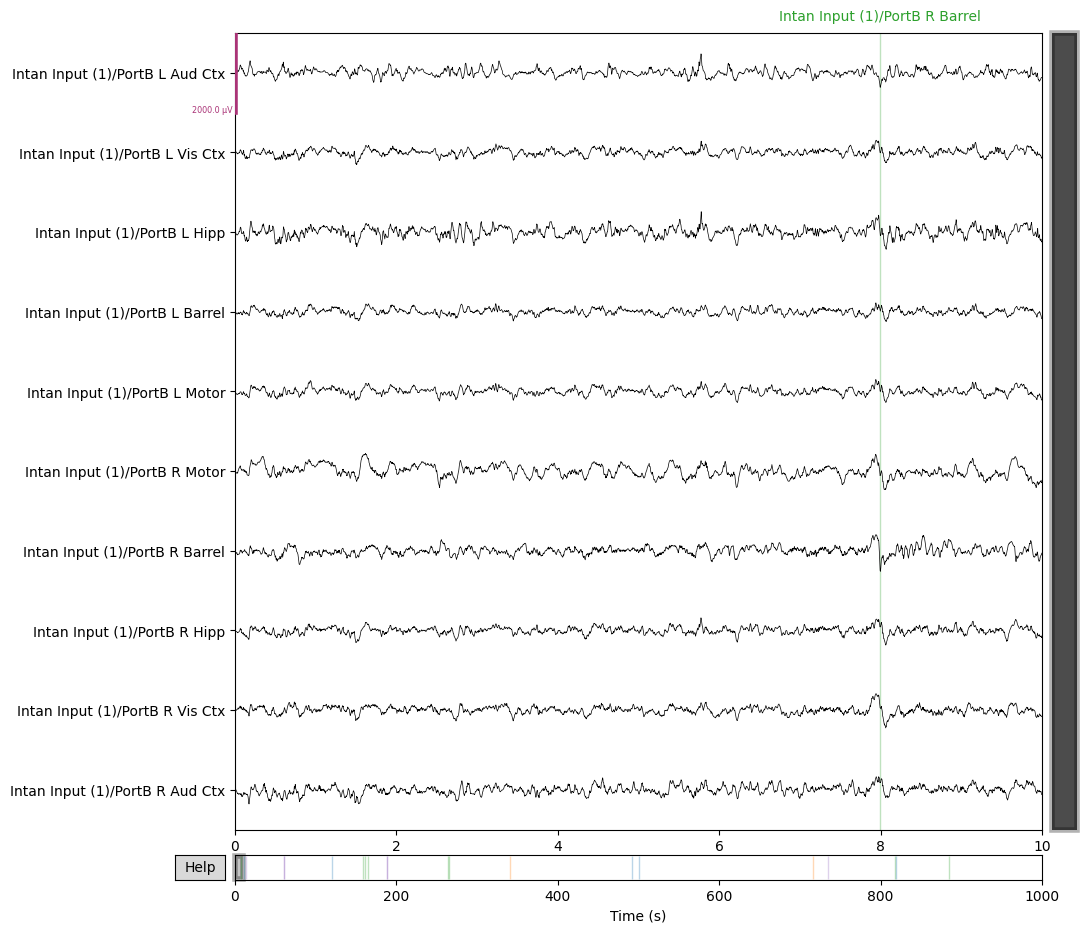

In [12]:
logger.setLevel(logging.INFO)
raw = raw.copy()
raw.load_data()
raw = raw.crop(tmin=0, tmax=1000)
raw = raw.filter(l_freq=constants.SORTING_PARAMS['freq_min'], h_freq=constants.SORTING_PARAMS['freq_max'])
raw.plot(duration=10, scalings=1e-3)

In [13]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

NameError: name 'war' is not defined

Channels marked as bad:
none


In [29]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for i, animal_id in enumerate(animal_ids):
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    if i == 1:
        # wrangle = war.result.copy()
        war_filt = war.filter_all(reject_channels=['LMot', 'RBar'], inplace=False)
        # wranglefilt = war_filt.result.copy()
        war = war_filt
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


2025-03-28 02:59:59,166 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,166 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,166 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,167 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,167 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,167 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,167 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-28 02:59:59,167 - WARNING - Intan

In [17]:
# for feat in constants.LINEAR_FEATURE + ['psdband']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, 'animal')
#     # display(df)
#     # ep.plot_boxplot_2(feat, ['genotype', 'animalday'], collapse_channels=False)
#     ep.plot_catplot(feat, 'animal', kind='violin')

# ep.plot_catplot('psdband', ['animal', 'isday', 'animalday'], 
#                 x='animal',
#                 col='isday',
#                 hue='band',
#                 kind='boxen',
#                 collapse_channels=False,
#                 catplot_params={'showfliers': False})

In [ ]:
# for feat in ['cohere']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, ['animal', 'isday'])
#     ep.plot_2d_feature_2(feat, ['animal', 'isday'], row='band')

2025-03-31 11:50:40,164 - DEBUG - groups: [('A10 KO Dec-13-2023', True), ('F22 KO Dec-12-2023', True)]
2025-03-31 11:50:40,167 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-31 11:50:40,168 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-31 11:50:40,189 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-03-31 11:50:40,191 - DEBUG - vals.shape: (117, 5, 10, 10)


2025-03-31 11:50:40,396 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13f0cdc0>
2025-03-31 11:50:40,433 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd140e2290>
2025-03-31 11:50:40,589 - DEBUG - groups: ['A10 KO Dec-13-2023', 'F22 KO Dec-12-2023']
2025-03-31 11:50:40,591 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-31 11:50:40,592 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-31 11:50:40,597 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-03-31 11:50:40,598 - DEBUG - vals.shape: (117, 5, 10, 10)


/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:556: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-03-31 11:50:41,183 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13ce0a00>
2025-03-31 11:50:41,213 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13b23550>
2025-03-31 11:50:41,240 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13b8d150>
2025-03-31 11:50:41,283 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13bd69e0>
2025-03-31 11:50:41,313 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13a40730>
2025-03-31 11:50:41,353 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13a6ebf0>
2025-03-31 11:50:41,390 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd13acfb80>
2025-03-31 11:50:41,424 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd139373d0>
2025-03-31 11:50:41,460 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd1397eb90>
2025-03-31 11:50:41,494 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd139e7490>


/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:556: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:556: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:556: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:556: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:556: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-03-31 11:50:42,056 - DEBUG - groups: [('KO', True)]
2025-03-31 11:50:42,057 - DEBUG - vals.shape: (31, 10, 10)
2025-03-31 11:50:42,061 - DEBUG - vals.shape: (117, 10, 10)
2025-03-31 11:50:42,516 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd5430ace0>
2025-03-31 11:50:42,610 - DEBUG - groups: ['KO']
2025-03-31 11:50:42,613 - DEBUG - vals.shape: (31, 10, 10)
2025-03-31 11:50:42,615 - DEBUG - vals.shape: (117, 10, 10)
2025-03-31 11:50:42,696 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fcd5418a380>


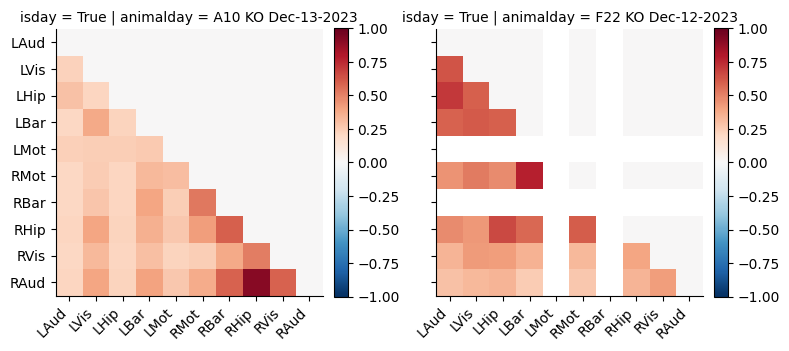

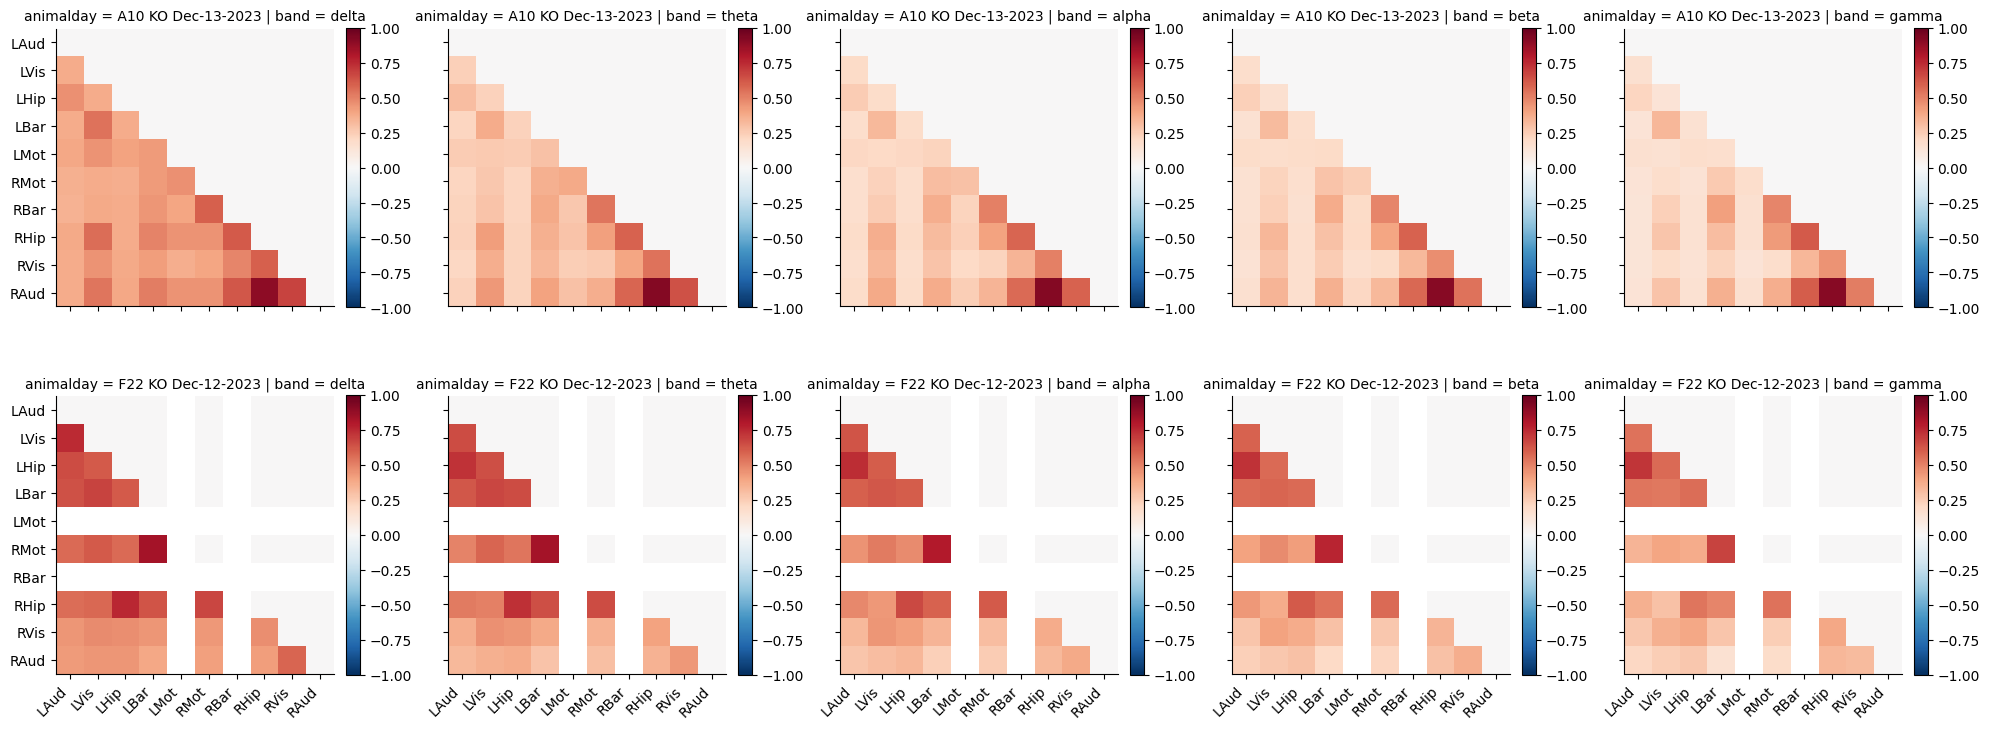

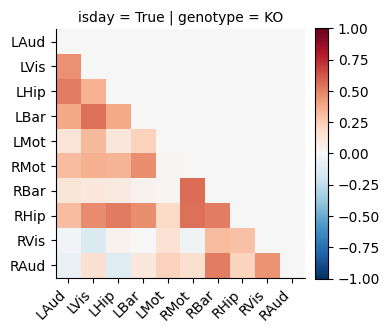

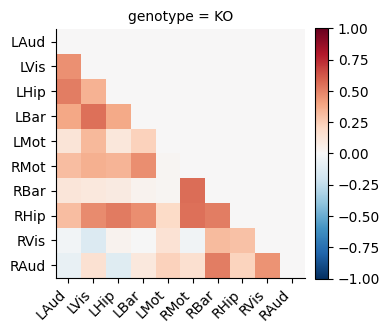

In [19]:
ep.plot_2d_feature_2('cohere', groupby=['animalday', 'isday'])
ep.plot_2d_feature_2('cohere', groupby='animalday', col='band', row='animalday')

ep.plot_2d_feature_2('pcorr', groupby=['genotype', 'isday'])
ep.plot_2d_feature_2('pcorr', groupby='genotype')

2025-03-28 03:00:12,155 - DEBUG - groups: ['KO']
2025-03-28 03:00:12,156 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:12,158 - DEBUG - vals.shape: (117, 10)
2025-03-28 03:00:12,304 - DEBUG - groups: ['KO']
2025-03-28 03:00:12,305 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:12,305 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:12,362 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:12,363 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:12,364 - DEBUG - vals.shape: (117, 10)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:12,507 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:12,507 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:12,508 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:12,584 - DEBUG - groups: ['KO']
2025-03-28 03:00:12,584 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:12,585 - DEBUG - vals.shape: (117, 10)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:12,740 - DEBUG - groups: ['KO']
2025-03-28 03:00:12,742 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:12,743 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:12,812 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:12,815 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:12,816 - DEBUG - vals.shape: (117, 10)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:12,981 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:12,982 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:12,983 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:13,070 - DEBUG - groups: ['KO']
2025-03-28 03:00:13,070 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:13,073 - DEBUG - vals.shape: (117, 10)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:13,254 - DEBUG - groups: ['KO']
2025-03-28 03:00:13,257 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:13,258 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:13,327 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:13,328 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:13,329 - DEBUG - vals.shape: (117, 10)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:13,655 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:13,656 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:13,657 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:13,734 - DEBUG - groups: ['KO']
2025-03-28 03:00:13,735 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:13,736 - DEBUG - vals.shape: (117, 10)
2025-03-28 03:00:13,859 - DEBUG - groups: ['KO']


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:13,860 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:13,860 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:13,923 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:13,923 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:13,924 - DEBUG - vals.shape: (117, 10)
2025-03-28 03:00:14,052 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:14,053 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:14,054 - DEBUG - vals.shape: (117,)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:14,124 - DEBUG - groups: ['KO']
2025-03-28 03:00:14,124 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:14,125 - DEBUG - vals.shape: (117, 10)
2025-03-28 03:00:14,265 - DEBUG - groups: ['KO']
2025-03-28 03:00:14,265 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:14,266 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:14,335 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:14,335 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:14,336 - DEBUG - vals.shape: (117, 10)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:14,493 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:14,494 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:14,495 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:14,570 - DEBUG - groups: ['KO']
2025-03-28 03:00:14,571 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:14,572 - DEBUG - vals.shape: (117, 10)
2025-03-28 03:00:14,691 - DEBUG - groups: ['KO']
2025-03-28 03:00:14,691 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:14,692 - DEBUG - vals.shape: (117,)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/Users/josephdong/PyEEG/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:14,752 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:14,753 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:00:14,754 - DEBUG - vals.shape: (117, 10)
2025-03-28 03:00:14,903 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:14,904 - DEBUG - vals.shape: (31,)
2025-03-28 03:00:14,905 - DEBUG - vals.shape: (117,)
2025-03-28 03:00:14,979 - DEBUG - groups: ['KO']
2025-03-28 03:00:14,980 - DEBUG - vals.shape: (31, 10, 2)
2025-03-28 03:00:14,981 - DEBUG - vals.shape: (117, 10, 2)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:15,121 - DEBUG - groups: ['KO']
2025-03-28 03:00:15,122 - DEBUG - vals.shape: (31, 2)
2025-03-28 03:00:15,123 - DEBUG - vals.shape: (117, 2)
2025-03-28 03:00:15,185 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:15,185 - DEBUG - vals.shape: (31, 10, 2)
2025-03-28 03:00:15,186 - DEBUG - vals.shape: (117, 10, 2)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:15,360 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:15,361 - DEBUG - vals.shape: (31, 2)
2025-03-28 03:00:15,362 - DEBUG - vals.shape: (117, 2)
2025-03-28 03:00:15,479 - DEBUG - groups: ['KO']
2025-03-28 03:00:15,479 - DEBUG - vals.shape: (31, 10, 2)
2025-03-28 03:00:15,586 - DEBUG - vals.shape: (117, 10, 2)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:15,729 - DEBUG - groups: ['KO']
2025-03-28 03:00:15,730 - DEBUG - vals.shape: (31, 2)
2025-03-28 03:00:15,731 - DEBUG - vals.shape: (117, 2)
2025-03-28 03:00:15,801 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:15,802 - DEBUG - vals.shape: (31, 10, 2)
2025-03-28 03:00:15,803 - DEBUG - vals.shape: (117, 10, 2)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:15,950 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:15,951 - DEBUG - vals.shape: (31, 2)
2025-03-28 03:00:15,952 - DEBUG - vals.shape: (117, 2)
2025-03-28 03:00:16,028 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:16,029 - DEBUG - vals.shape: (31, 5)
2025-03-28 03:00:16,031 - DEBUG - vals.shape: (117, 5)
2025-03-28 03:00:16,132 - DEBUG - groups: ['KO']
2025-03-28 03:00:16,132 - DEBUG - vals.shape: (31, 5)
2025-03-28 03:00:16,134 - DEBUG - vals.shape: (117, 5)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-03-28 03:00:16,227 - DEBUG - groups: [('KO', True)]
2025-03-28 03:00:16,228 - DEBUG - vals.shape: (31, 5)
2025-03-28 03:00:16,229 - DEBUG - vals.shape: (117, 5)
2025-03-28 03:00:16,328 - DEBUG - groups: ['KO']
2025-03-28 03:00:16,329 - DEBUG - vals.shape: (31, 5)
2025-03-28 03:00:16,330 - DEBUG - vals.shape: (117, 5)


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:109: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


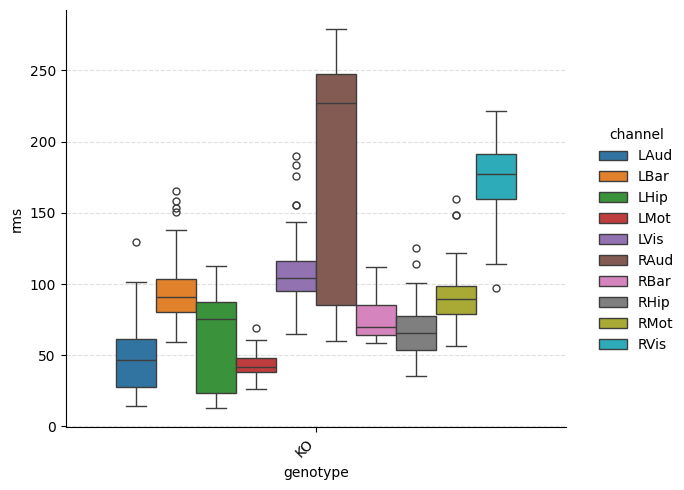

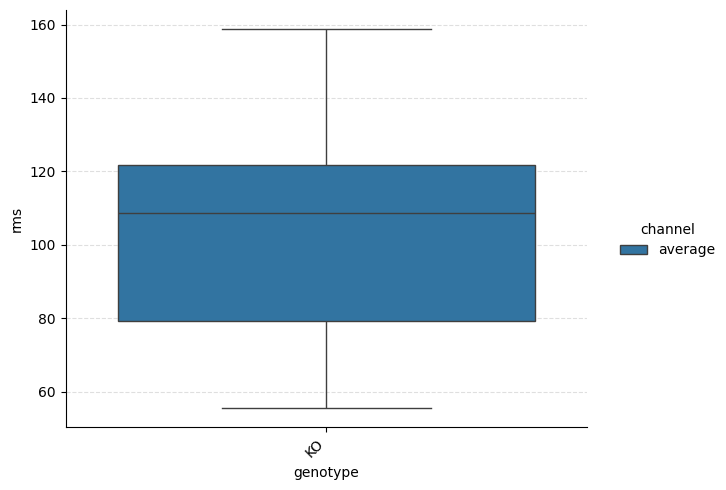

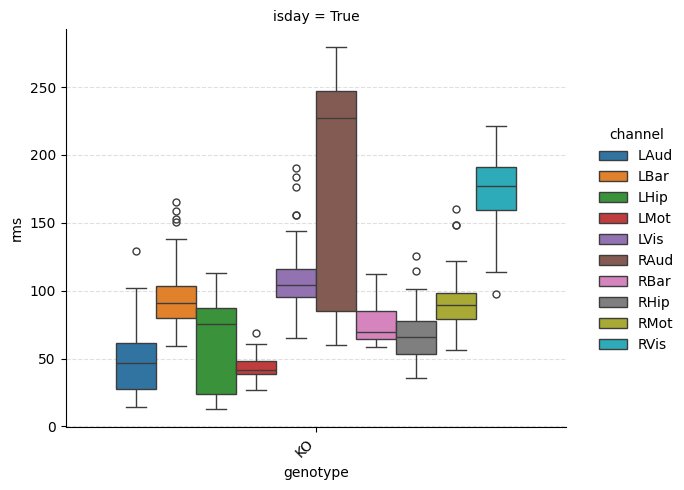

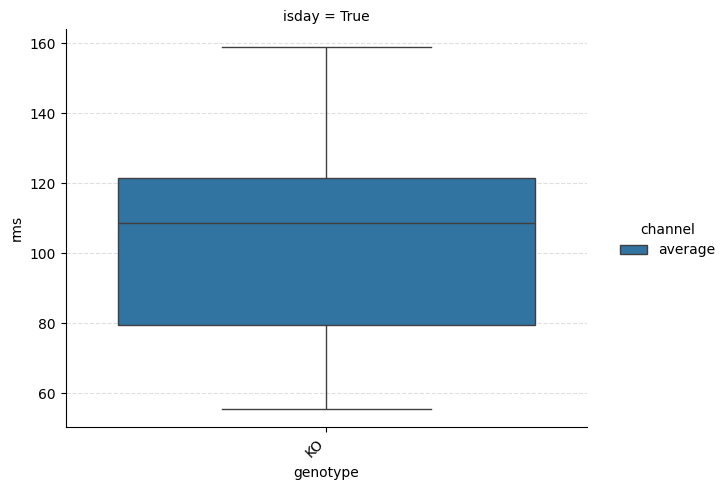

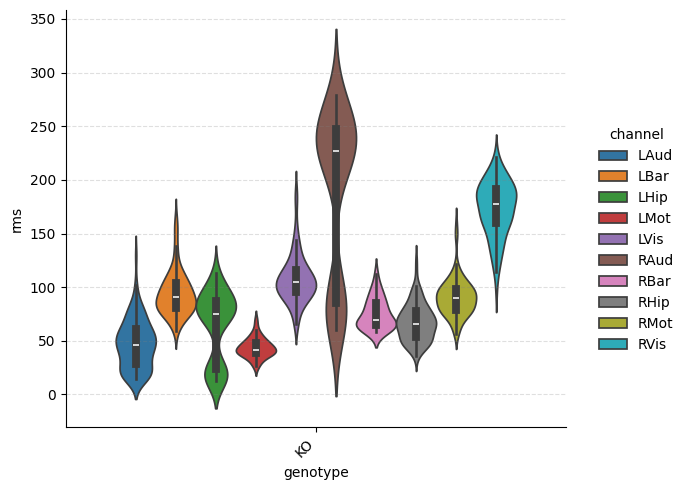

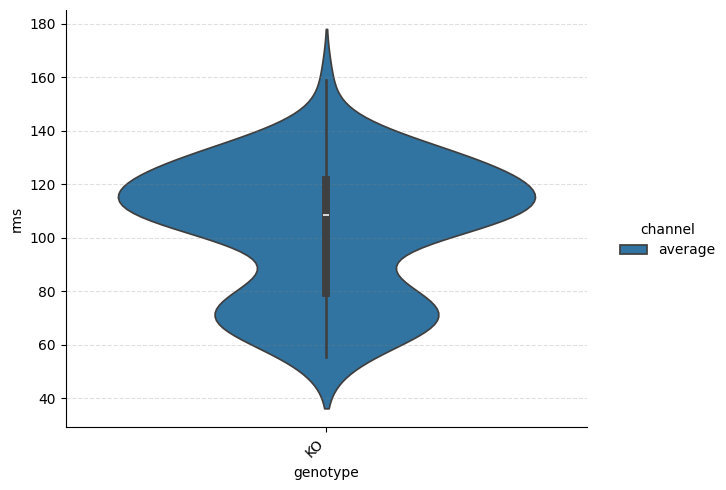

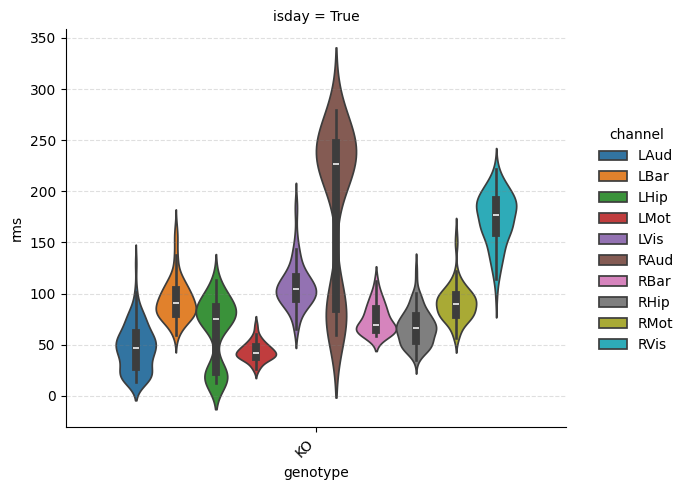

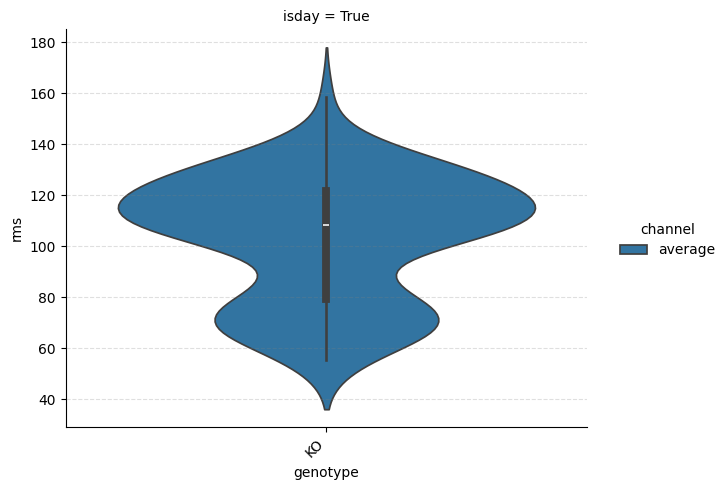

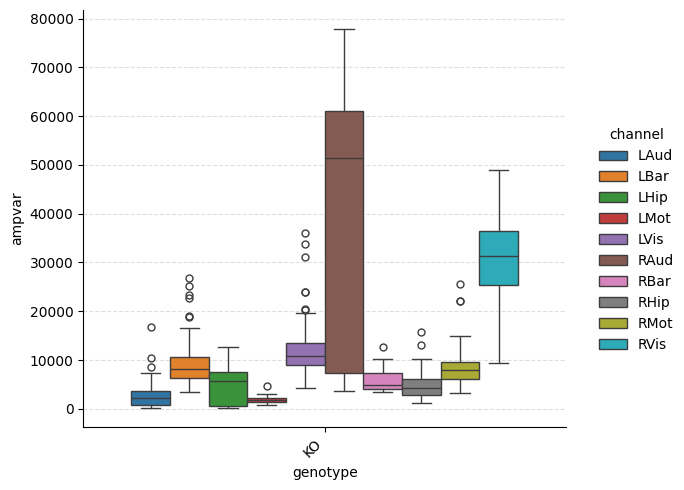

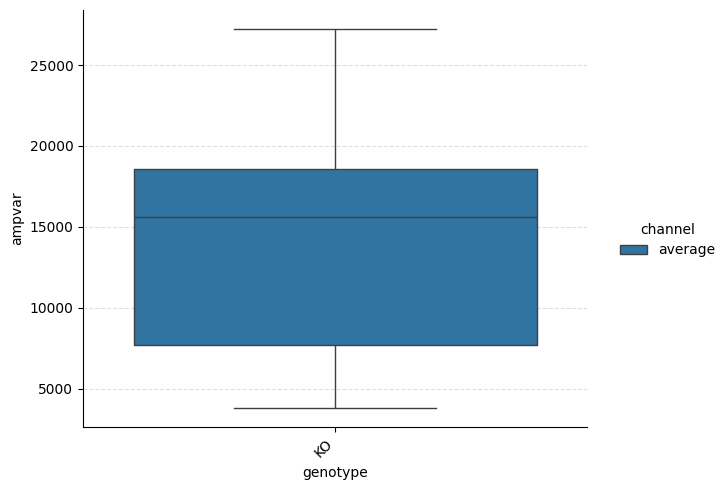

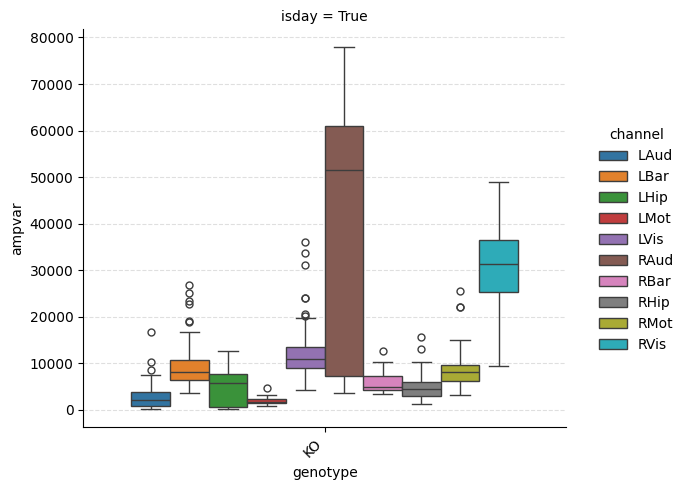

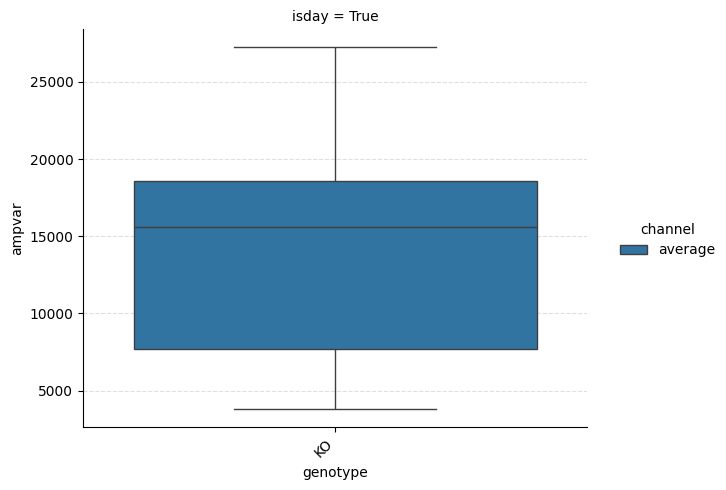

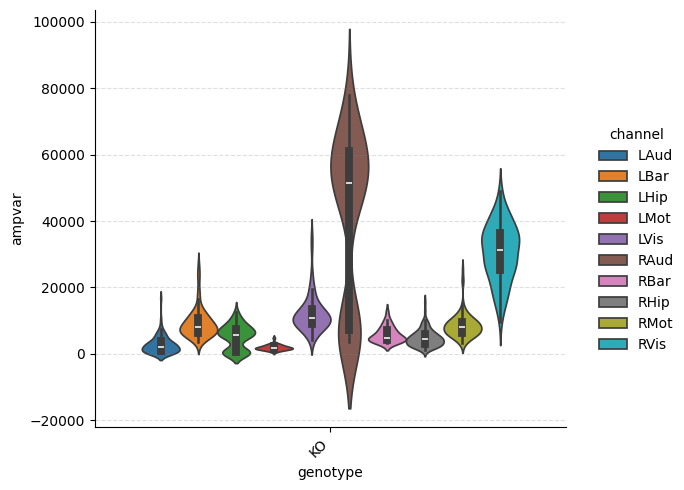

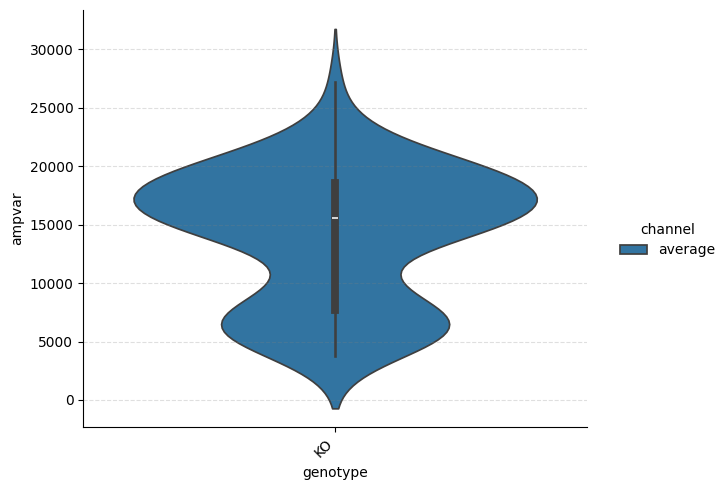

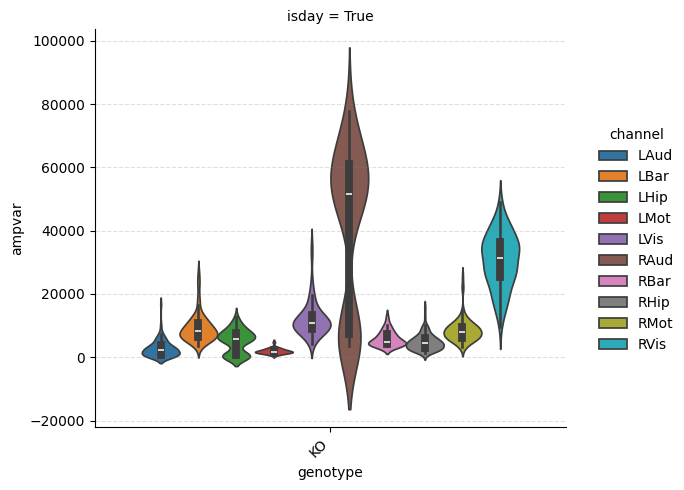

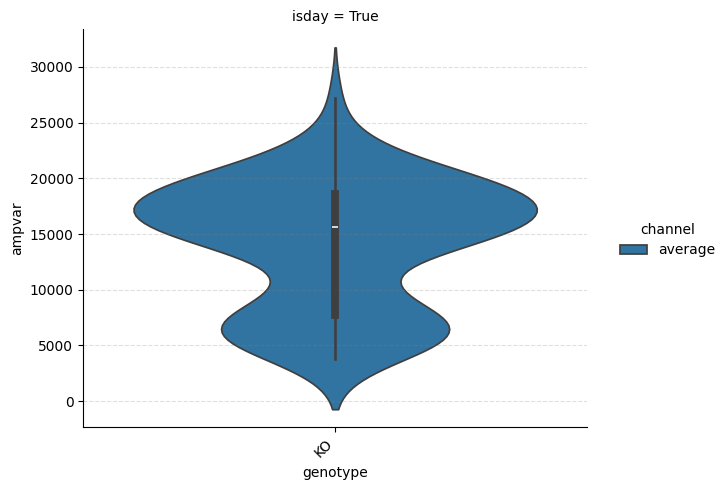

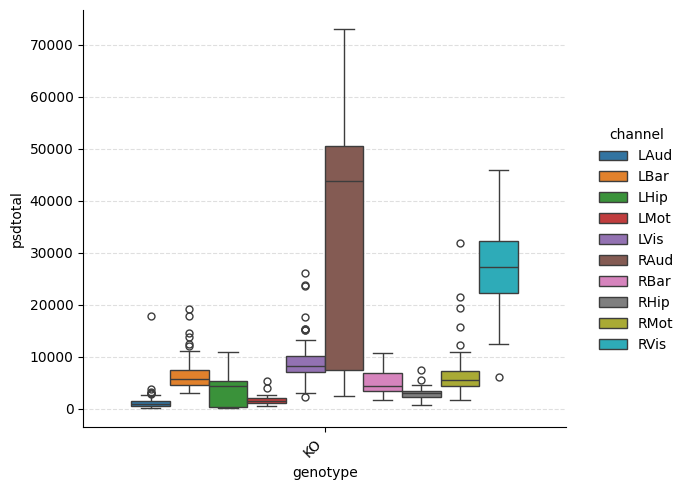

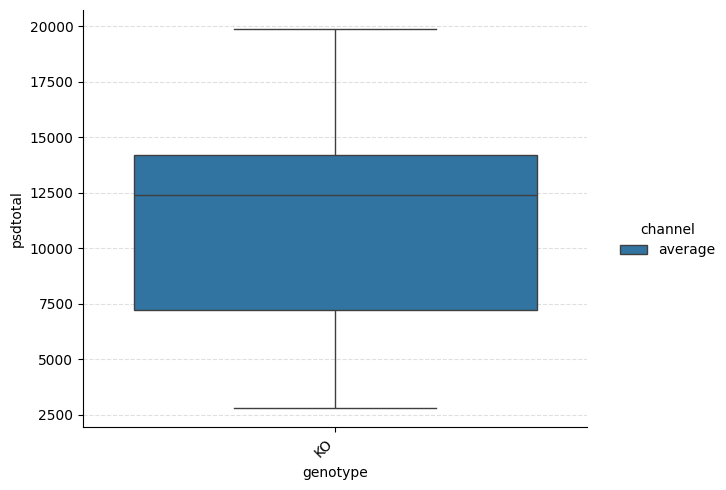

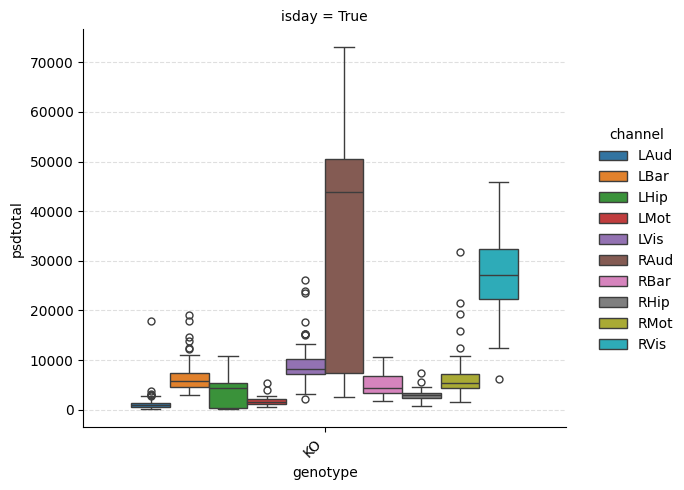

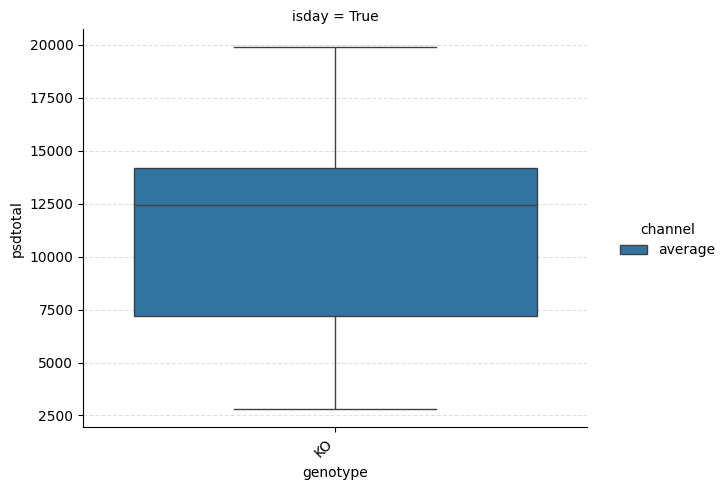

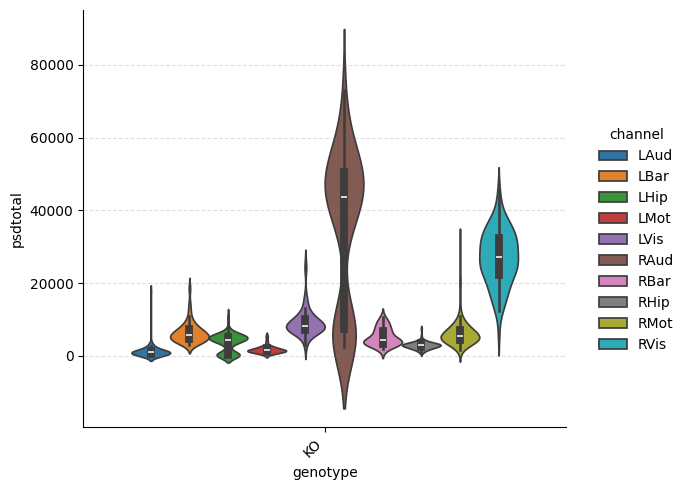

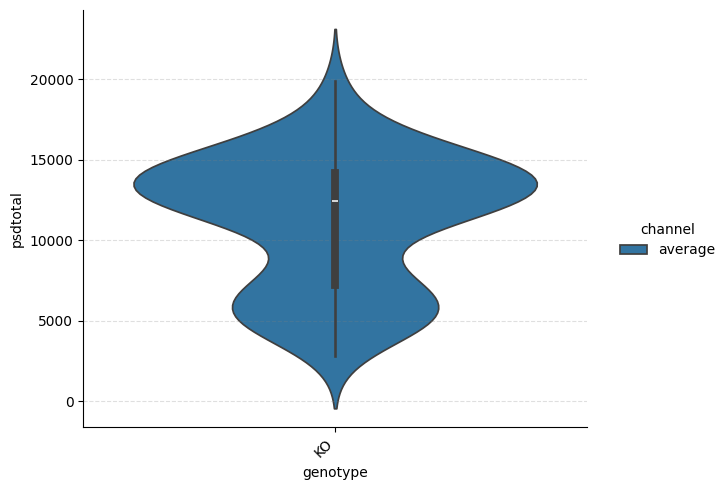

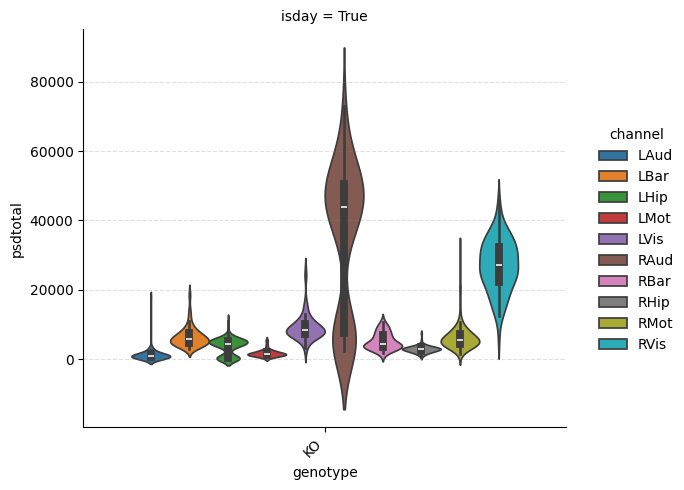

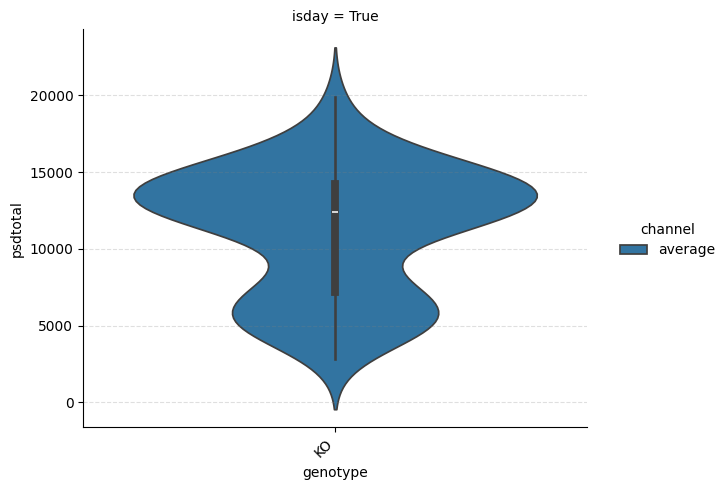

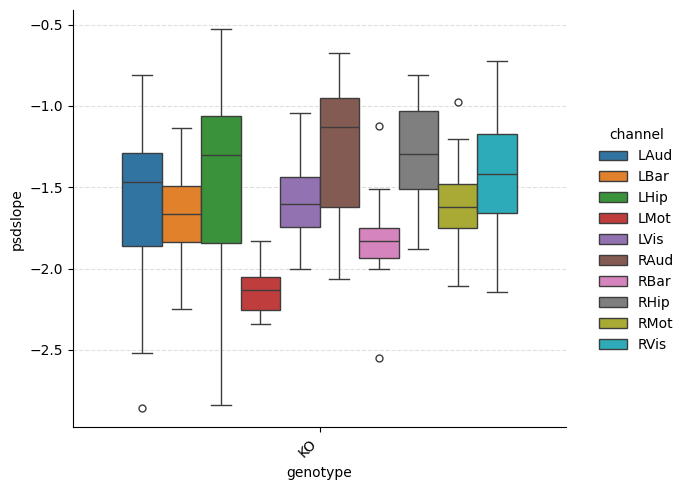

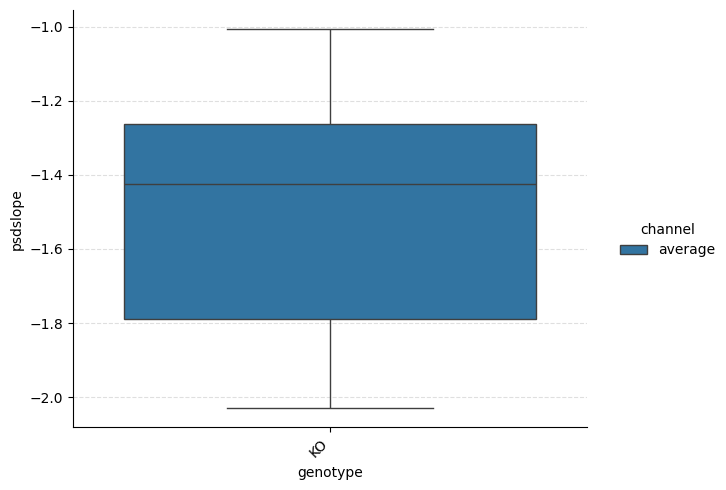

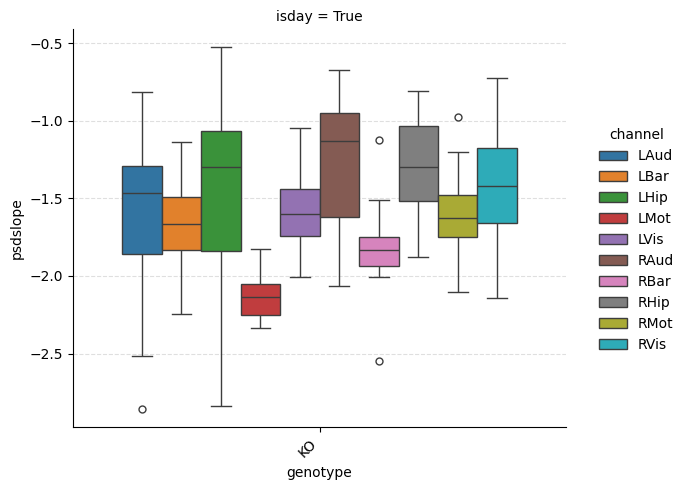

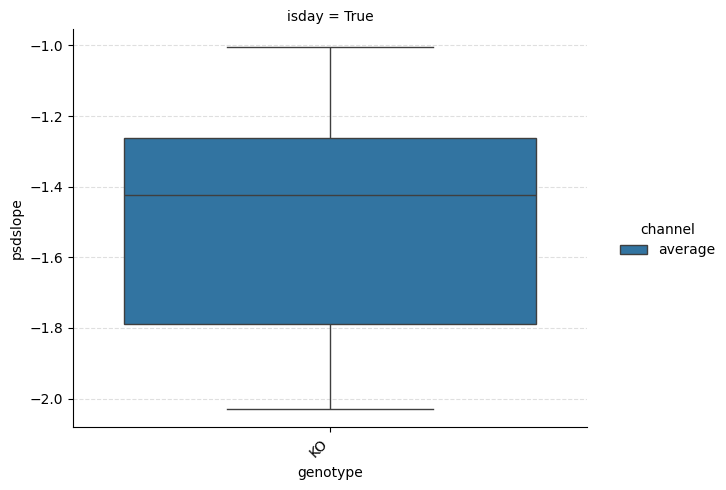

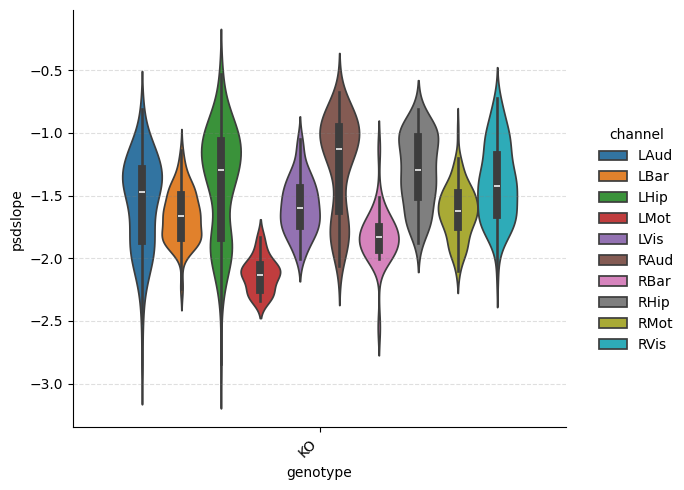

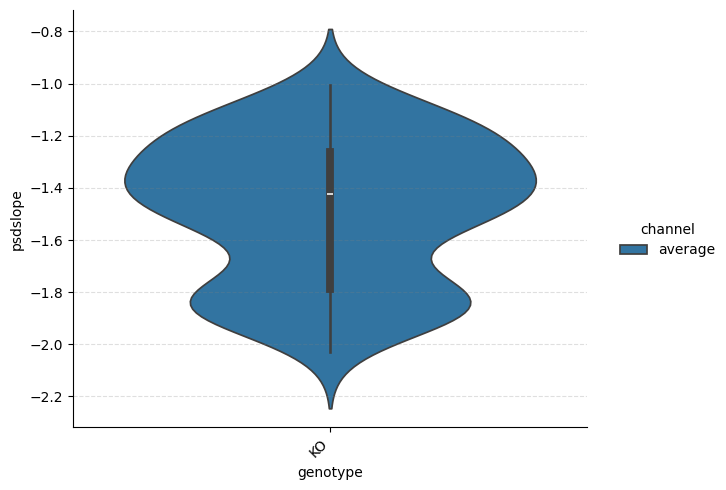

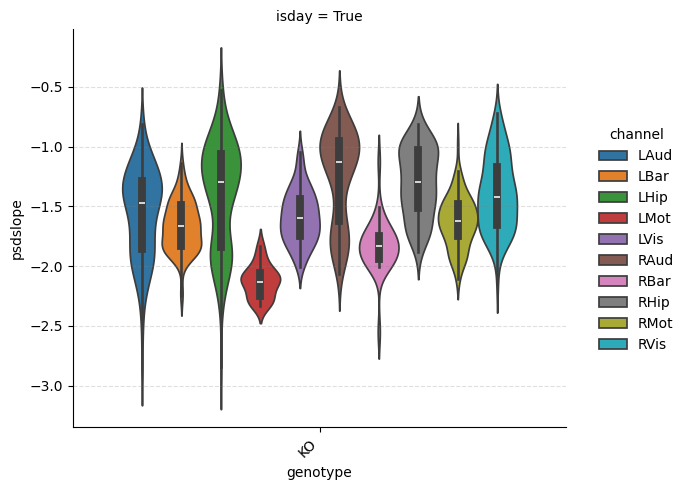

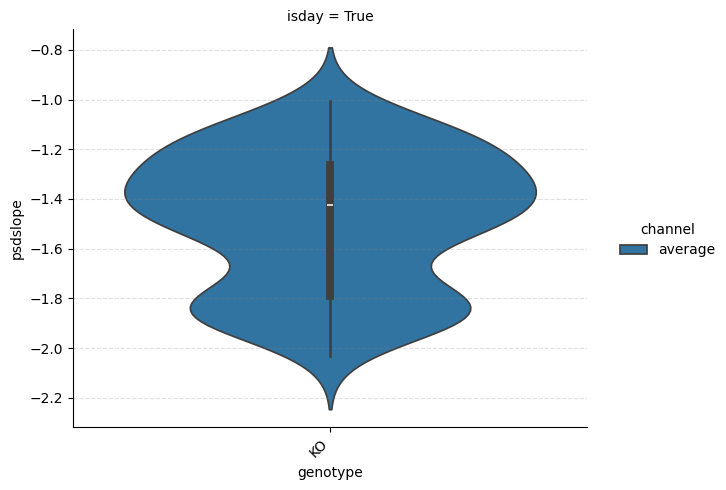

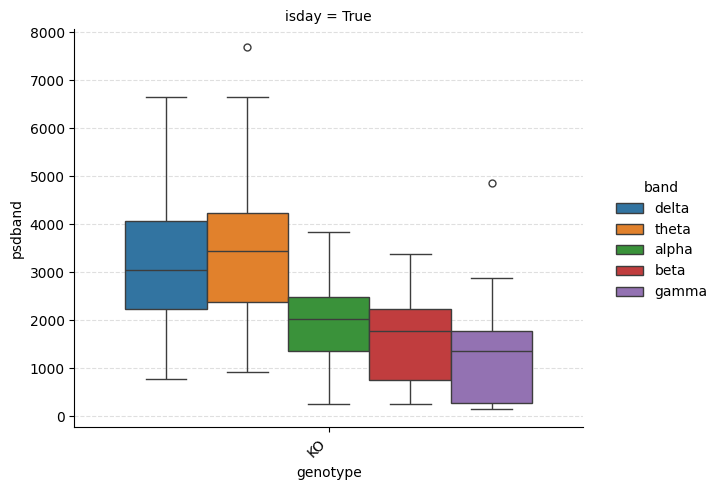

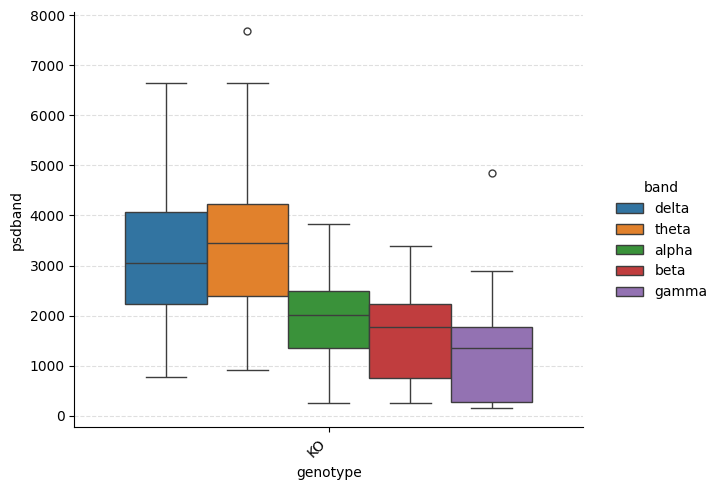

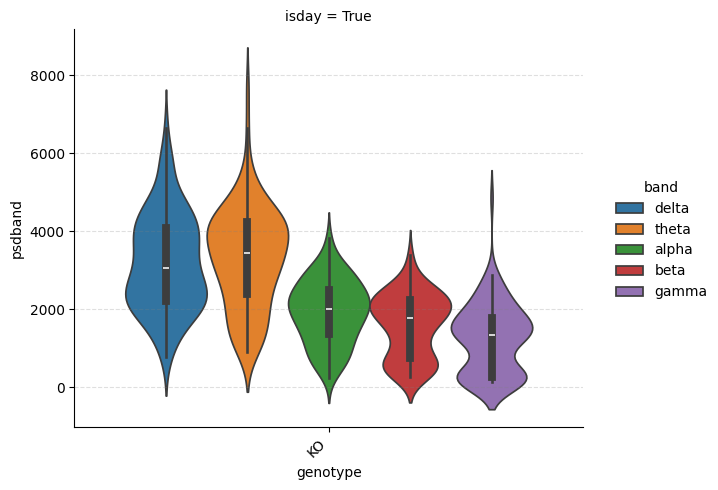

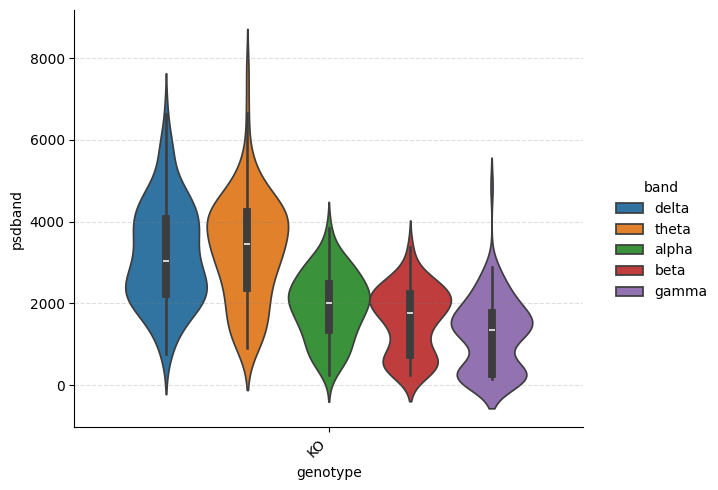

In [33]:
for feature in constants.LINEAR_FEATURE:
    for kind in ['box', 'violin']:
        for groupby in ['genotype', ['genotype', 'isday']]:
            for collapse in [False, True]:
                ep.plot_catplot(feature, groupby=groupby, kind=kind, collapse_channels=collapse)
for kind in ['box', 'violin']:
    ep.plot_catplot('psdband', groupby=['genotype', 'isday'], 
                    x='genotype',
                    col='isday',
                    hue='band',
                    kind=kind, collapse_channels=True)
    ep.plot_catplot('psdband', groupby=['genotype'], 
                    x='genotype',
                    hue='band',
                    kind=kind, collapse_channels=True)

2025-03-28 03:34:26,859 - DEBUG - groups: ['A10', 'F22']
2025-03-28 03:34:26,860 - DEBUG - vals.shape: (31, 10)
2025-03-28 03:34:26,862 - DEBUG - vals.shape: (117, 10)


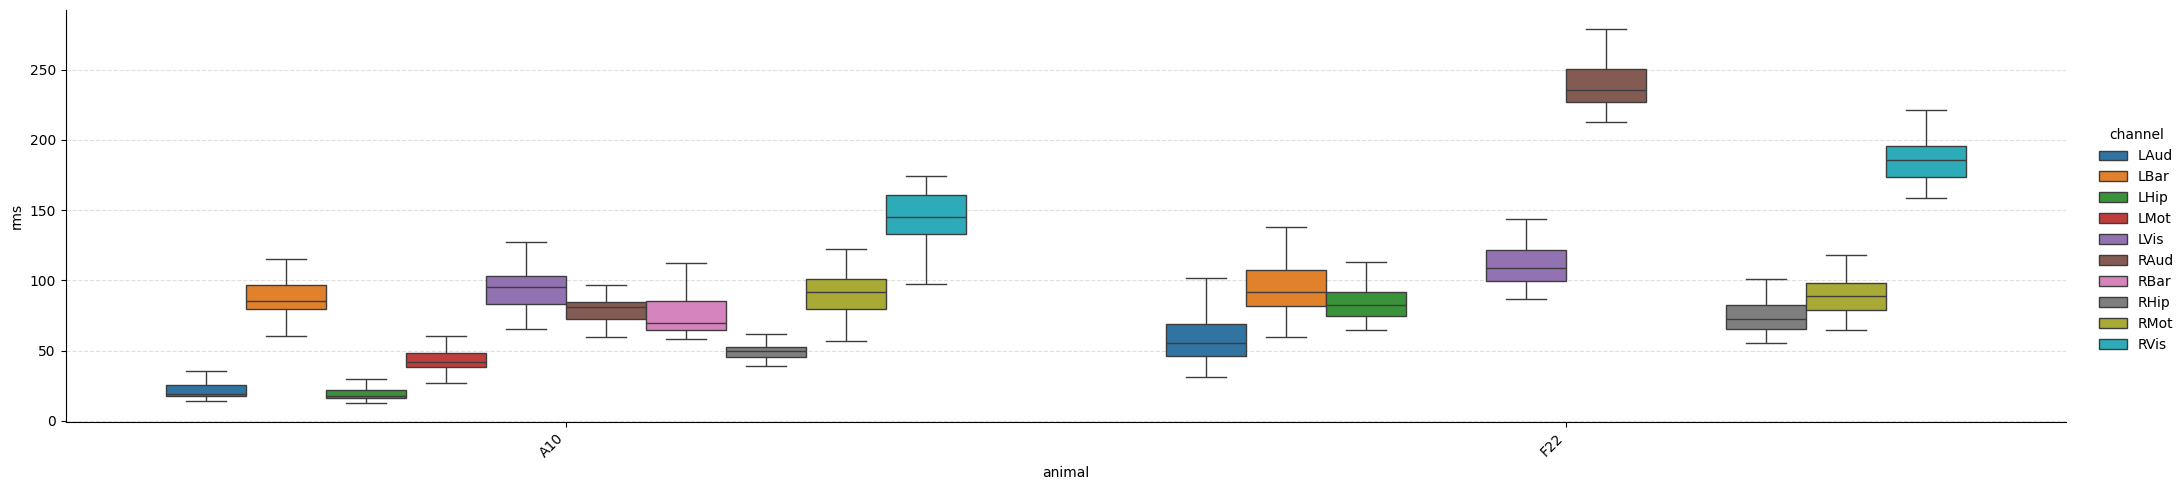

In [43]:
ep.plot_catplot('rms', groupby='animal', kind='box', catplot_params={'showfliers': False, 'aspect': 4})

2025-03-28 02:56:03,155 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x140f7b7c0>
2025-03-28 02:56:03,170 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x140f1e440>
2025-03-28 02:56:03,237 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x141638ca0>
2025-03-28 02:56:03,258 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x1416f3c40>
2025-03-28 02:56:03,278 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x1417cc850>


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:664: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:781: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:781: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:781: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:781: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-03-28 02:56:03,396 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x1413aa4d0>
2025-03-28 02:56:03,421 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x141275990>


/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/experiment.py:781: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


(<Figure size 800x1500 with 15 Axes>,
 array([[<Axes: title={'center': 'A10'}, ylabel='delta'>,
         <Axes: title={'center': 'F22'}>],
        [<Axes: ylabel='theta'>, <Axes: >],
        [<Axes: ylabel='alpha'>, <Axes: >],
        [<Axes: ylabel='beta'>, <Axes: >],
        [<Axes: ylabel='gamma'>, <Axes: >]], dtype=object),
 None)

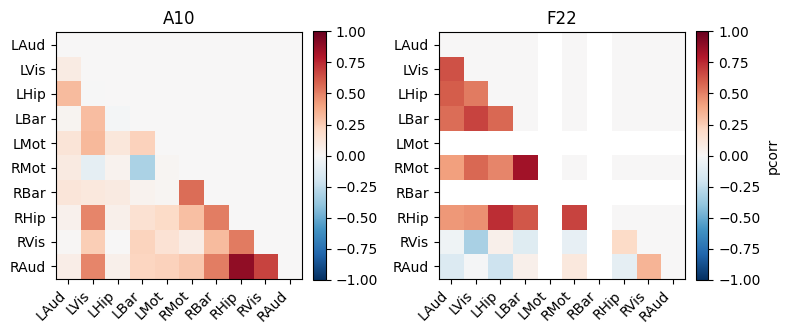

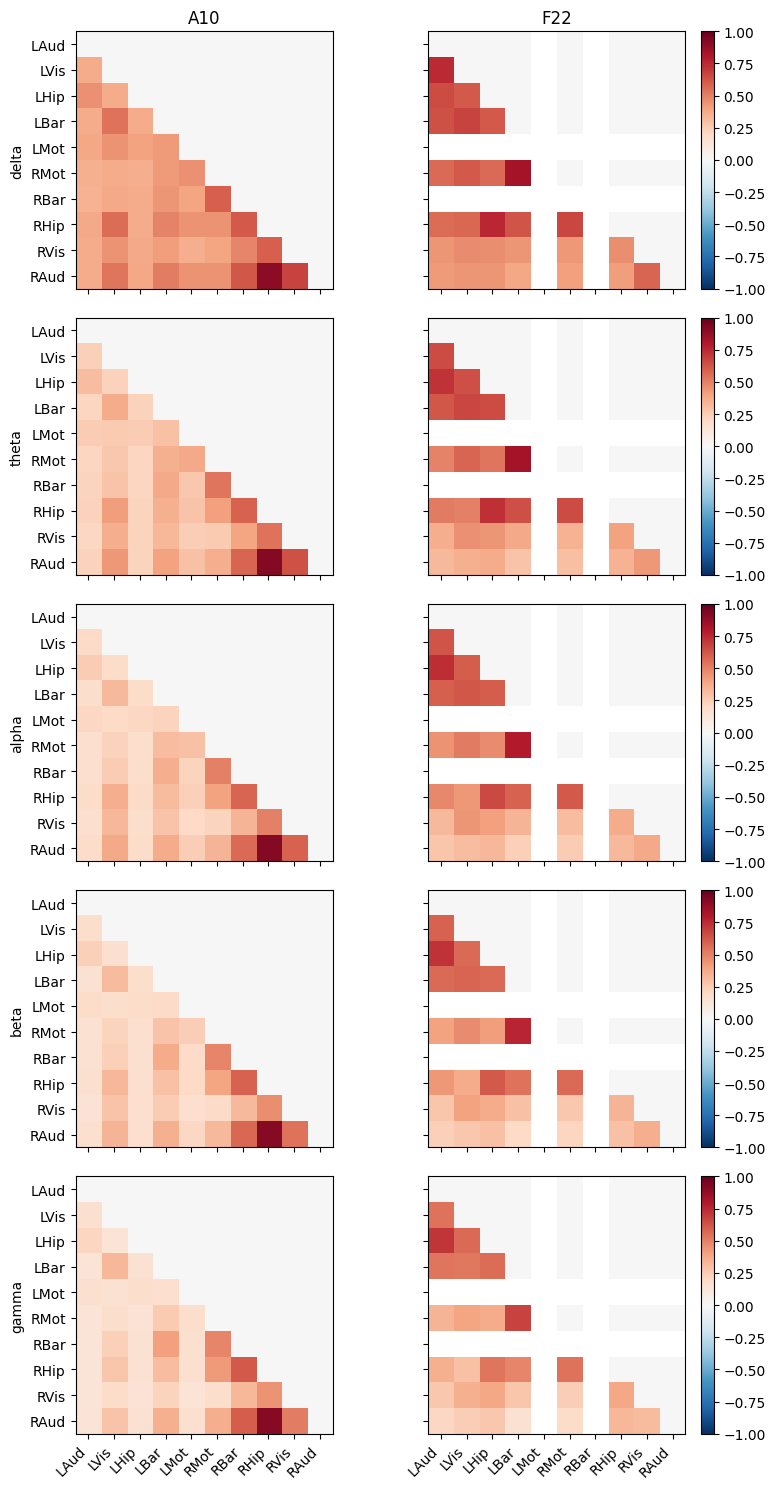

In [ ]:
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

In [16]:
logger.setLevel(logging.DEBUG)

In [ ]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


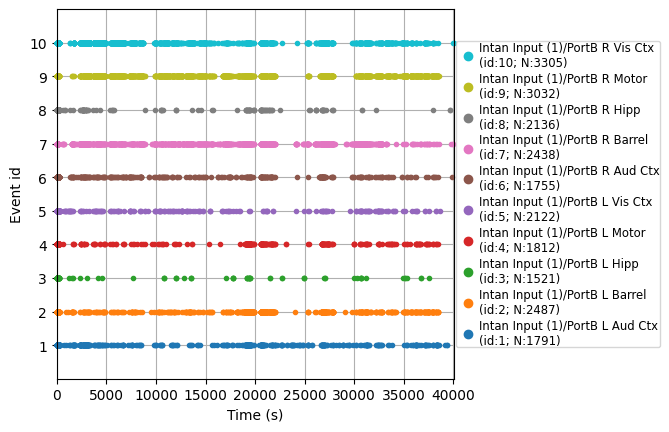

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)